## Decision Tree Code

#### Libraries and packages

In [228]:
from __future__ import annotations
from collections import Counter
from typing import Dict, List, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Useful functions

In [229]:
def compute_error(R: Union[np.ndarray, pd.Series], criterion: str = "gini"):
    unique_classes, count_classes = np.unique(R[-1], return_counts=True)
    classes_ratios = count_classes / sum(count_classes)
    if criterion == "entropy":
        return -sum(np.multiply(classes_ratios, np.log(classes_ratios)))
    else:
        return sum(np.multiply(classes_ratios, 1 - classes_ratios))

    
def split_node(
    R_m: Union[np.ndarray, pd.DataFrame], t: Union[float, str], feature_type: str = "real"
) -> Iterable[np.array]:
    if feature_type == "real":
        mask = R_m[0] < t
    else:
        mask = R_m[0] == t
    return R_m[:, mask], R_m[:, ~mask]


def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    criterion: str = "gini",
    feature_type: str = "real"
    ) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или энтропии нужно выбирать порог с наименьшим значением.

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param criterion: либо `gini`, либо `entropy`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки
    :return q_values: вектор со значениями функционала ошибки для каждого из порогов в thresholds len(q_values) == len(thresholds)
    :return threshold_best: оптимальный порог
    :return q_value_best: значение функционала ошибки при оптимальном разбиении
    """
    feature_vector = np.array([feature_vector, target_vector])
    if feature_type == "real":
        unique_feature_values = np.sort(np.unique(feature_vector[0]))
        thresholds = np.array([(unique_feature_values[i] + unique_feature_values[i - 1]) / 2
                               for i in range(1, len(unique_feature_values))])
    else:
        thresholds = np.unique(feature_vector[0])
    
    q_values = []
    for t in thresholds:
        left_tree, right_tree = split_node(feature_vector, t, feature_type)
        error = (len(left_tree) * compute_error(left_tree, criterion) +
                len(right_tree) * compute_error(right_tree, criterion)) / len(feature_vector)
        q_values.append(error)
    
    q_values = np.array(q_values)
    q_value_best = np.min(q_values)
    threshold_best = thresholds[np.argmin(q_values)]
    return thresholds, q_values, threshold_best, q_value_best

#### Class DecisionTree

In [230]:
class DecisionTree():
    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = np.inf,
        min_samples_split: int = 1,
        min_samples_leaf: int = 1,
        criterion: str = 'gini'
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self._criterion = criterion

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict,
        depth: int
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]) or (len(sub_y) < self._min_samples_split) or depth == self._max_depth:
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, q_value_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, q_value = find_best_split(feature_vector, sub_y, self._criterion, feature_type)
            
            if q_value_best is None or q_value > q_value_best:
                feature_prev = feature_best
                q_value_prev = q_value_best
                feature_best = feature
                q_value_best = q_value

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = (feature_vector < threshold_best)
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = (feature_vector == threshold_best)
                else:
                    raise ValueError
                # проверяем, что поддеревья не пустые и в них достаточно много листьев
                if np.all(split == True) or np.all(split == False) or np.sum(split) < self._min_samples_leaf or \
                        len(split) - np.sum(split) < self._min_samples_leaf:
                    feature_best = None
                    q_value_best = None

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"], depth + 1)
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"], depth + 1)

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево
        в зависимости от значения предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        while node["type"] == "nonterminal":
            feature_split = node["feature_split"]
            if self._feature_types[feature_split] == "real":
                if x[feature_split] < node["threshold"]:
                    node = node["left_child"]
                else:
                    node = node["right_child"]
            else:
                if x[feature_split] == node["category_split"]:
                    node = node["left_child"]
                else:
                    node = node["right_child"]
        
        return node["class"]

    def fit(self, X: np.ndarray, y: np.ndarray) -> DecisionTree:
        self._fit_node(X, y, self._tree, depth = 0)
        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X.values:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)

## Images

In [231]:
from PIL import Image

#### Downloading Little-Rock, Arkansas, USA 2022-06-08 satellite image from https://apps.sentinel-hub.com/sentinel-playground

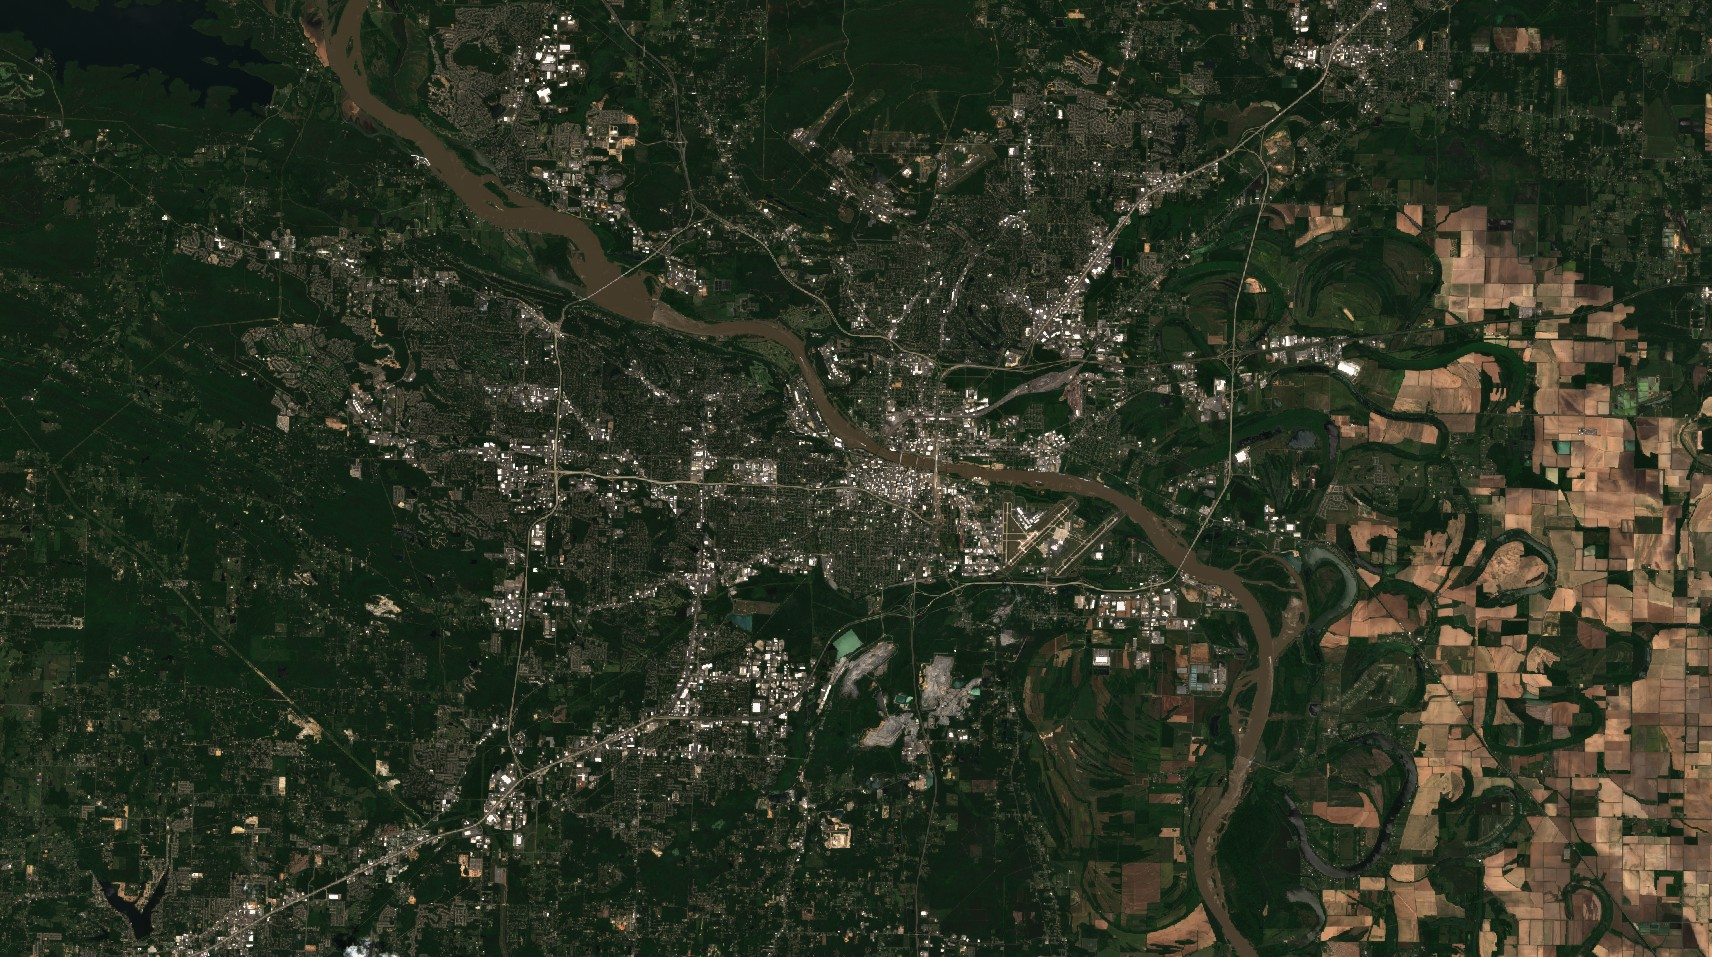

In [232]:
overview = Image.open('Arkansas-2022-06-08.jpg')
overview

Let's cut the image so as to get a small square picture.

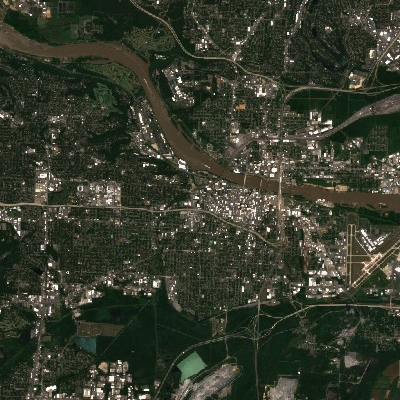

In [233]:
overview_matrix_full = np.asarray(overview)
overview_matrix = []
for i in range(len(overview_matrix_full) // 2 - 200, len(overview_matrix_full) // 2 + 200):
    overview_matrix.append([])
    for j in range(len(overview_matrix_full[i]) // 2 - 200, len(overview_matrix_full[i]) // 2 + 200):
        overview_matrix[i - len(overview_matrix_full) // 2 + 200].append(overview_matrix_full[i][j])
overview_matrix = np.asarray(overview_matrix, dtype=np.uint8)
overview_small = Image.fromarray(overview_matrix)
overview_small

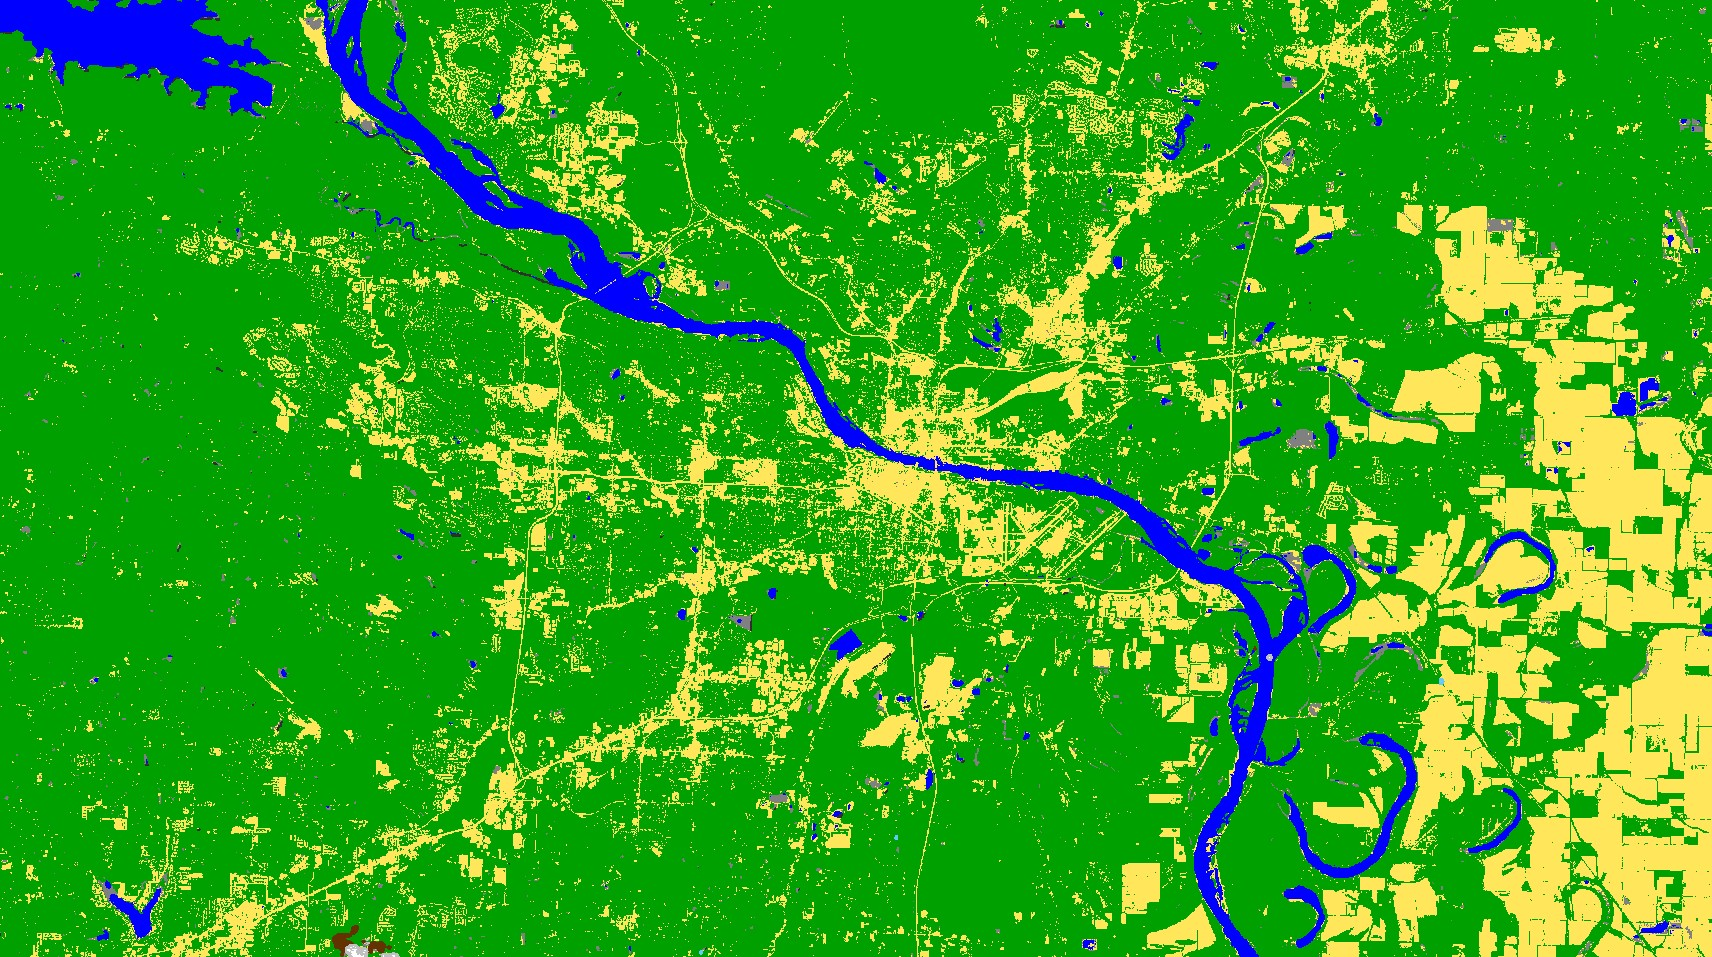

In [234]:
bad_classification = Image.open('Arkansas-2022-06-08-classificated.jpg')
bad_classification

Let's cut the image so as to get a small square picture.

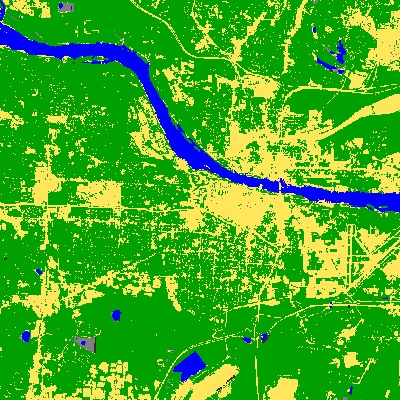

In [235]:
bad_classification_matrix_full = np.asarray(bad_classification)
bad_classification_matrix = []
for i in range(len(bad_classification_matrix_full) // 2 - 200, len(bad_classification_matrix_full) // 2 + 200):
    bad_classification_matrix.append([])
    for j in range(len(bad_classification_matrix_full[i]) // 2 - 200, len(bad_classification_matrix_full[i]) // 2 + 200):
        bad_classification_matrix[i - len(bad_classification_matrix_full) // 2 + 200].append(bad_classification_matrix_full[i][j])
bad_classification_matrix = np.asarray(bad_classification_matrix, dtype=np.uint8)
bad_classification_small = Image.fromarray(bad_classification_matrix)
bad_classification_small

Unfortunately, there are different shades of blue (water), green (vegetation) and yellow (urban and other), so we'll change the classificated picture so as there are only 4 different colors: blue, green, yellow and white (Unknown).

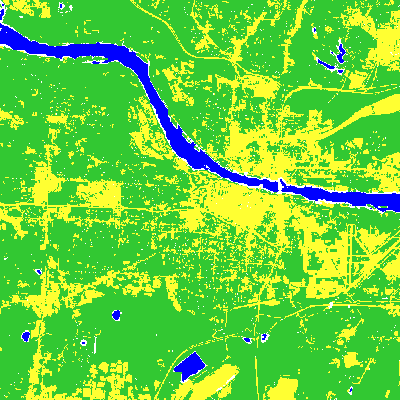

In [236]:
bad_classification_array = np.reshape(bad_classification_matrix, (400 * 400, 3))
good_classification = []
Blue = [0, 0, 255]
Green = [50, 200, 50]
Yellow = [255, 255, 50]
White = [255, 255, 255]
for pixel in bad_classification_array:
    R, G, B = pixel[0], pixel[1], pixel[2]
    error = 100
    if Blue[0] - error < R < Blue[0] + error and Blue[1] - error < G < Blue[1] + error and Blue[2] - error < B < Blue[2] + error:
        good_classification.append(Blue)
        continue
    if Green[0] - error < R < Green[0] + error and Green[1] - error < G < Green[1] + error and Green[2] - error < B < Green[2] + error:
        good_classification.append(Green)
        continue
    if Yellow[0] - error < R < Yellow[0] + error and Yellow[1] - error < G < Yellow[1] + error and Yellow[2] - error < B < Yellow[2] + error:
        good_classification.append(Yellow)
        continue
    good_classification.append(White)
good_classification = np.asarray(good_classification, dtype=np.uint8)
good_classification = np.reshape(good_classification, (400, 400, 3))
good_classification_img = Image.fromarray(good_classification)
good_classification_img

## Training and testing

In [237]:
from sklearn.model_selection import train_test_split

data = np.reshape(overview_matrix, (400 * 400, 3))
X = pd.DataFrame(data, columns=['R', 'G', 'B'])
good_classification_array = np.reshape(good_classification, (400 * 400, 3))
y = []
for i in range(400 * 400):
    pixel = [good_classification_array[i][j] for j in range(3)]
    if pixel == Blue:
        y.append('water')
        continue
    if pixel == Green:
        y.append('vegetation')
        continue
    if pixel == Yellow:
        y.append('urban')
        continue
    y.append('Unknown')
y = pd.Series(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

feature_types = ['categorical'] * 3

custom_tree = DecisionTree(feature_types)
custom_tree.fit(np.array(X_train), np.array(y_train))

predictions = custom_tree.predict(X_test)

Let's calculate the accuracy of our predictions

In [238]:
from sklearn.metrics import accuracy_score

print('Accuracy:', accuracy_score(y_test, predictions))

Accuracy: 0.88365


## Classifying images

#### Downloading two Little-Rock, Arkansas, USA satellite images, 5 years apart

In [239]:
img_1 = Image.open('Arkansas-2017-06-01.jpg')
img_2 = Image.open('Arkansas-2022-06-01.jpg')

In [240]:
img_1_matrix_full = np.asarray(img_1)
img_1_matrix = []
for i in range(len(img_1_matrix_full) // 2 - 200, len(img_1_matrix_full) // 2 + 200):
    img_1_matrix.append([])
    for j in range(len(img_1_matrix_full[i]) // 2 - 200, len(img_1_matrix_full[i]) // 2 + 200):
        img_1_matrix[i - len(img_1_matrix_full) // 2 + 200].append(img_1_matrix_full[i][j])
img_1_matrix = np.asarray(img_1_matrix, dtype=np.uint8)
img_1_small = Image.fromarray(img_1_matrix)

img_2_matrix_full = np.asarray(img_2)
img_2_matrix = []
for i in range(len(img_2_matrix_full) // 2 - 200, len(img_2_matrix_full) // 2 + 200):
    img_2_matrix.append([])
    for j in range(len(img_2_matrix_full[i]) // 2 - 200, len(img_2_matrix_full[i]) // 2 + 200):
        img_2_matrix[i - len(img_2_matrix_full) // 2 + 200].append(img_2_matrix_full[i][j])
img_2_matrix = np.asarray(img_2_matrix, dtype=np.uint8)
img_2_small = Image.fromarray(img_2_matrix)

#### Little-Rock, Arkansas, USA, 2017-06-01

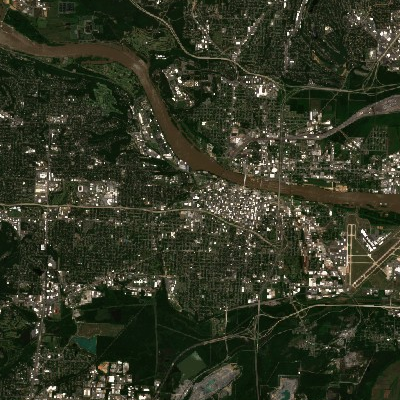

In [241]:
img_1_small

#### Little-Rock, Arkansas, USA, 2022-06-01

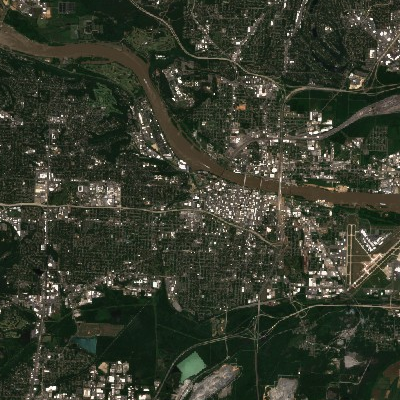

In [242]:
img_2_small

Let's classify each Little-Rock image after training the Tree on Little-Rock 2022-06-08 image.

In [243]:
data_1 = np.reshape(img_1_matrix, (400 * 400, 3))
X_1 = pd.DataFrame(data_1, columns=['R', 'G', 'B'])

data_2 = np.reshape(img_2_matrix, (400 * 400, 3))
X_2 = pd.DataFrame(data_2, columns=['R', 'G', 'B'])

feature_types = ['categorical'] * 3

custom_tree = DecisionTree(feature_types)
custom_tree.fit(np.array(X_train), np.array(y_train))

predictions_1 = custom_tree.predict(X_1)
predictions_2 = custom_tree.predict(X_2)

In [244]:
classification_array_1 = []
for prediction in predictions_1:
    if prediction == 'water':
        classification_array_1.append(Blue)
        continue
    if prediction == 'vegetation':
        classification_array_1.append(Green)
        continue
    if prediction == 'urban':
        classification_array_1.append(Yellow)
        continue
    classification_array_1.append(White)
classification_array_1 = np.asarray(classification_array_1, dtype=np.uint8)
classification_1 = np.reshape(classification_array_1, (400, 400, 3))
img_classification_1 = Image.fromarray(classification_1)

classification_array_2 = []
for prediction in predictions_2:
    if prediction == 'water':
        classification_array_2.append(Blue)
        continue
    if prediction == 'vegetation':
        classification_array_2.append(Green)
        continue
    if prediction == 'urban':
        classification_array_2.append(Yellow)
        continue
    classification_array_2.append(White)
classification_array_2 = np.asarray(classification_array_2, dtype=np.uint8)
classification_2 = np.reshape(classification_array_2, (400, 400, 3))
img_classification_2 = Image.fromarray(classification_2)

#### Little-Rock, Arkansas, USA, 2017-06-01, classificated

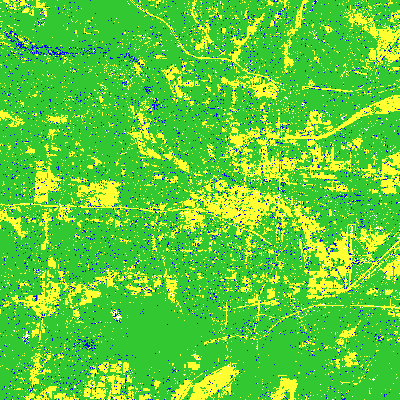

In [245]:
img_classification_1

#### Little-Rock, Arkansas, USA, 2022-06-01, classificated

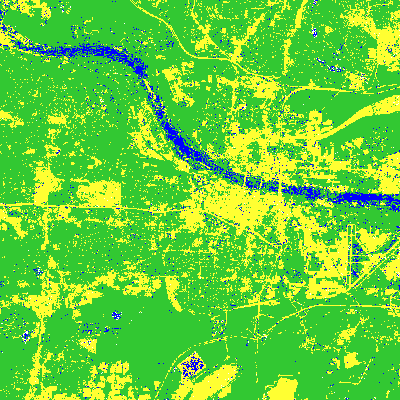

In [246]:
img_classification_2

## Getting binary change detection matrix

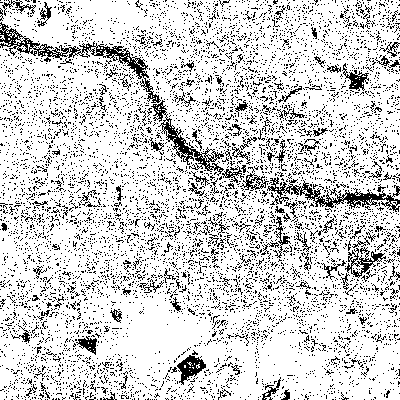

In [247]:
binary_array = []
for i in range(400):
    for j in range(400):
        pixel_1 = classification_1[i][j]
        pixel_2 = classification_2[i][j]
        if list(pixel_1) == list(pixel_2):
            binary_array.append([255, 255, 255])
        else:
            binary_array.append([0, 0, 0])
binary_array = np.asarray(binary_array, dtype=np.uint8)
binary_matrix = np.reshape(binary_array, (400, 400, 3))
binary_img = Image.fromarray(binary_matrix)
binary_img

At least we can say that, apparently, the color of the river has changed throughout 5 years.